In [1]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from fovperi.fov.fov2 import getFov, reverseMapPixel, reverseMapPixel_Initial, generate_fovea 

from pytorch_lightning.loggers import WandbLogger

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class FoveatedCompression:
    def __init__(self, N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False):
        self.N = N
        self.p0 = p0
        self.Nr = Nr
        self.bio_foveation = bio_foveation
        self.add_coords = add_coords
        self.fovCenter = int((N - 2 * p0) / 2)
        self.fovSize = 2 * (p0 + Nr) + 1
        self.fovX, self.fovY = N // 2 - self.p0, N // 2 - self.p0

        # Initialize the reverse mapping and foveation functions
        # self.reverseMapPixel_Initial = reverseMapPixel_Initial(N=N, p0=p0, Nr=Nr, fovCenter=self.fovCenter, bio=bio_foveation)
        # self.reverseMapPixel = reverseMapPixel(N=N, p0=p0, Nr=Nr, bio=bio_foveation)
        self.getFovead = getFov(N=N, p0=p0, Nr=Nr, bio=bio_foveation, add_coords=add_coords)

    def foveated_compression(self, image):
        return np.array(self.getFovead(image, self.fovX, self.fovY, add_coords=False), dtype=np.uint8)
    
    def reconstruct(self, image):
        reconstructed, interpolated = self.getFovead(image, self.fovX, self.fovY, add_coords=False, reverse=True)
        return np.array(reconstructed, dtype=np.uint8), np.array(interpolated, dtype=np.uint8)


In [3]:
class FoveatedTransform:
    def __init__(self, N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False):
        self.foveated_compression = FoveatedCompression(N, p0, Nr, bio_foveation, add_coords)

    def __call__(self, tensor):
        # Convert tensor to numpy array
        tensor = torch.Tensor(tensor)
        array = np.array(tensor.permute(1,2,0)*255, dtype=np.uint8)
        # Apply foveated compression
        foveated_image = self.foveated_compression.foveated_compression(array)
        # Convert numpy array back to tensor
        return transforms.ToTensor()(foveated_image)

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [4]:
# Test the foveated compression
input_transforms = transforms.Compose([
    # To numpy array
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    FoveatedTransform(N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False),
    transforms.Resize((96, 96))
])

target_transform=transforms.Compose([
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # NEAREST is important for labels
            transforms.PILToTensor(),
            # divide by 255 to get values between 0 and 1
            transforms.Lambda(lambda mask: mask/255),  # Remove the channel dimension and convert to long
            FoveatedTransform(N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False),
            transforms.Resize((96, 96), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.Lambda(lambda mask: (255*mask[0, :, :]).long()),  # Remove the channel dimension and convert to long
        ])

train_dataset = datasets.Cityscapes(
    root='data/cityscapes', 
    split='train', 
    mode='fine',
    target_type='semantic',
    transform=input_transforms,
    target_transform=target_transform
)

In [5]:
images, masks = next(iter(train_dataset))

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [6]:
images.shape, masks.shape

(torch.Size([3, 96, 96]), torch.Size([96, 96]))

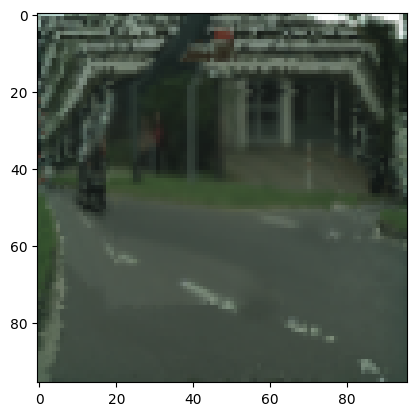

In [7]:
plt.imshow(images.permute(1,2,0))

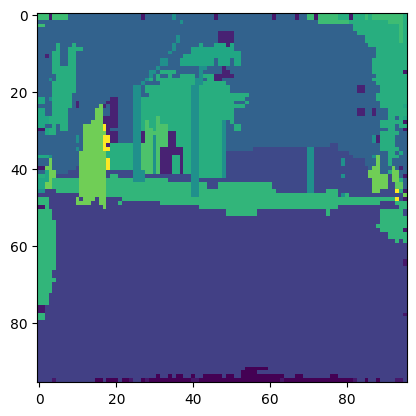

In [8]:
plt.imshow(masks)

In [9]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, num_classes, backbone='resnet101'):
        super().__init__()
        # Initialize the model with the specified backbone and number of classes
        self.model = smp.DeepLabV3Plus(
            encoder_name=backbone, 
            encoder_weights=None, 
            classes=num_classes,
            activation=None
        )

        # Resize
        self.size = (256, 256)

        self.foveated_transform = FoveatedTransform(N=256, p0=22, Nr=18, bio_foveation=True, add_coords=False)

        self.input_transform = transforms.Compose([
            transforms.Resize(self.size),
            transforms.ToTensor(),
            # transforms.Normalize(
                # mean=[0.485, 0.456, 0.406], 
                # std=[0.229, 0.224, 0.225]
            # )
            self.foveated_transform,
            transforms.Resize((96, 96))
        ])

        self.target_transform=transforms.Compose([
            transforms.Resize(self.size, interpolation=transforms.InterpolationMode.NEAREST), # NEAREST is important for labels
            transforms.PILToTensor(),
            # divide by 255 to get values between 0 and 1
            transforms.Lambda(lambda mask: mask/255),  # Remove the channel dimension and convert to long
            self.foveated_transform,
            transforms.Resize((96, 96), interpolation=transforms.InterpolationMode.NEAREST),
            transforms.Lambda(lambda mask: (255*mask[0, :, :]).long()),  # Remove the channel dimension and convert to long
        ])

    def forward(self, x):
        # Standard forward pass
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        # Forward pass
        output = self.forward(images)
        # Calculate loss
        loss = torch.nn.functional.cross_entropy(output, masks)
        # Logging
        self.log('train_loss', loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        output = self.forward(images)

        loss = torch.nn.functional.cross_entropy(output, masks)
        self.log('val_loss', loss.item())

    def test_step(self, batch, batch_idx):
        images, masks = batch
        output = self.forward(images)
        loss = torch.nn.functional.cross_entropy(output, masks)
        self.log('test_loss', loss.item())

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def train_dataloader(self):
        # Define the PyTorch dataset for Cityscapes
        train_dataset = datasets.Cityscapes(
            root='data/cityscapes', 
            split='train', 
            mode='fine',
            target_type='semantic',
            transform=self.input_transform,
            target_transform=self.target_transform
        )
        # Define the DataLoader
        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        return train_loader

    def val_dataloader(self):
        val_dataset = datasets.Cityscapes(
            root='data/cityscapes',
            split='val', 
            mode='fine',
            target_type='semantic',
            transform=self.input_transform,
            target_transform=self.target_transform
        )
        val_loader = DataLoader(val_dataset, batch_size=8)
        return val_loader
    
    def test_dataloader(self):
        test_dataset = datasets.Cityscapes(
            root='data/cityscapes',
            split='test', 
            mode='fine',
            target_type='semantic',
            transform=self.input_transform,
            target_transform=self.target_transform
        )
        test_loader = DataLoader(test_dataset, batch_size=4)
        return test_loader

In [10]:
# Initialize the model
model = SegmentationModel(num_classes=34)

logger = WandbLogger(project='foveated-segmentation', name='debug2')

# Initialize PyTorch Lightning trainer
trainer = pl.Trainer(max_epochs=5, logger=logger)

# # Train the model
trainer.fit(model)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michelleappel. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name  | Type          | Params
----------------------------------------
0 | model | DeepLabV3Plus | 45.7 M
----------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.713   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
c:\Users\appel\anaconda3\envs\ML\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfor

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 372/372 [06:42<00:00,  0.92it/s, v_num=iohk]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 372/372 [06:45<00:00,  0.92it/s, v_num=iohk]


# Plot Results

### Plot functions

In [11]:
def decode_seg_map_sequence(label_masks, dataset='cityscapes'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks

mapping_20 = { 
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 1,
    8: 2,
    9: 0,
    10: 0,
    11: 3,
    12: 4,
    13: 5,
    14: 0,
    15: 0,
    16: 0,
    17: 6,
    18: 0,
    19: 7,
    20: 8,
    21: 9,
    22: 10,
    23: 11,
    24: 12,
    25: 13,
    26: 14,
    27: 15,
    28: 16,
    29: 0,
    30: 0,
    31: 17,
    32: 18,
    33: 19,
    -1: 0
}

def decode_segmap(label_mask, dataset='cityscapes', plot=False):
    """Decode segmentation class labels into a color image
    Args:
        label_mask (np.ndarray): an (M,N) array of integer values denoting
          the class label at each spatial location.
        plot (bool, optional): whether to show the resulting color image
          in a figure.
    Returns:
        (np.ndarray, optional): the resulting decoded color image.
    """

    if dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
        # Remapping using mapping_20
        for k, v in mapping_20.items():
            label_mask[label_mask == k] = v


    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll, 0]
        g[label_mask == ll] = label_colours[ll, 1]
        b[label_mask == ll] = label_colours[ll, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb



def get_cityscapes_labels():
    return np.array([
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]])


In [12]:
def plot_segmentation(images, masks, out):
    """
    Plots the segmentation masks for the whole batch.

    Args:
        images (Tensor): A batch of images.
        masks (Tensor): A batch of masks.
        out (Tensor): A batch of predicted masks.
    """
    num_images = images.size(0)
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    for i in range(num_images):
        axs[i, 0].imshow(images[i].permute(1, 2, 0))
        axs[i, 0].set_title('Original Image')
        decode_segmap(np.array(masks[i]), plot=False)
        axs[i, 1].imshow(decode_segmap(np.array(masks[i])))
        axs[i, 1].set_title('True Mask')
        decode_segmap(np.array(out.argmax(1)[i]), plot=False)
        axs[i, 2].imshow(decode_segmap(np.array(out.argmax(1)[i])))
        axs[i, 2].set_title('Predicted Mask')
    plt.show()

## Results

In [13]:
images, masks = next(iter(model.val_dataloader()))

In [14]:
model.model.eval()
out = model.model(images)

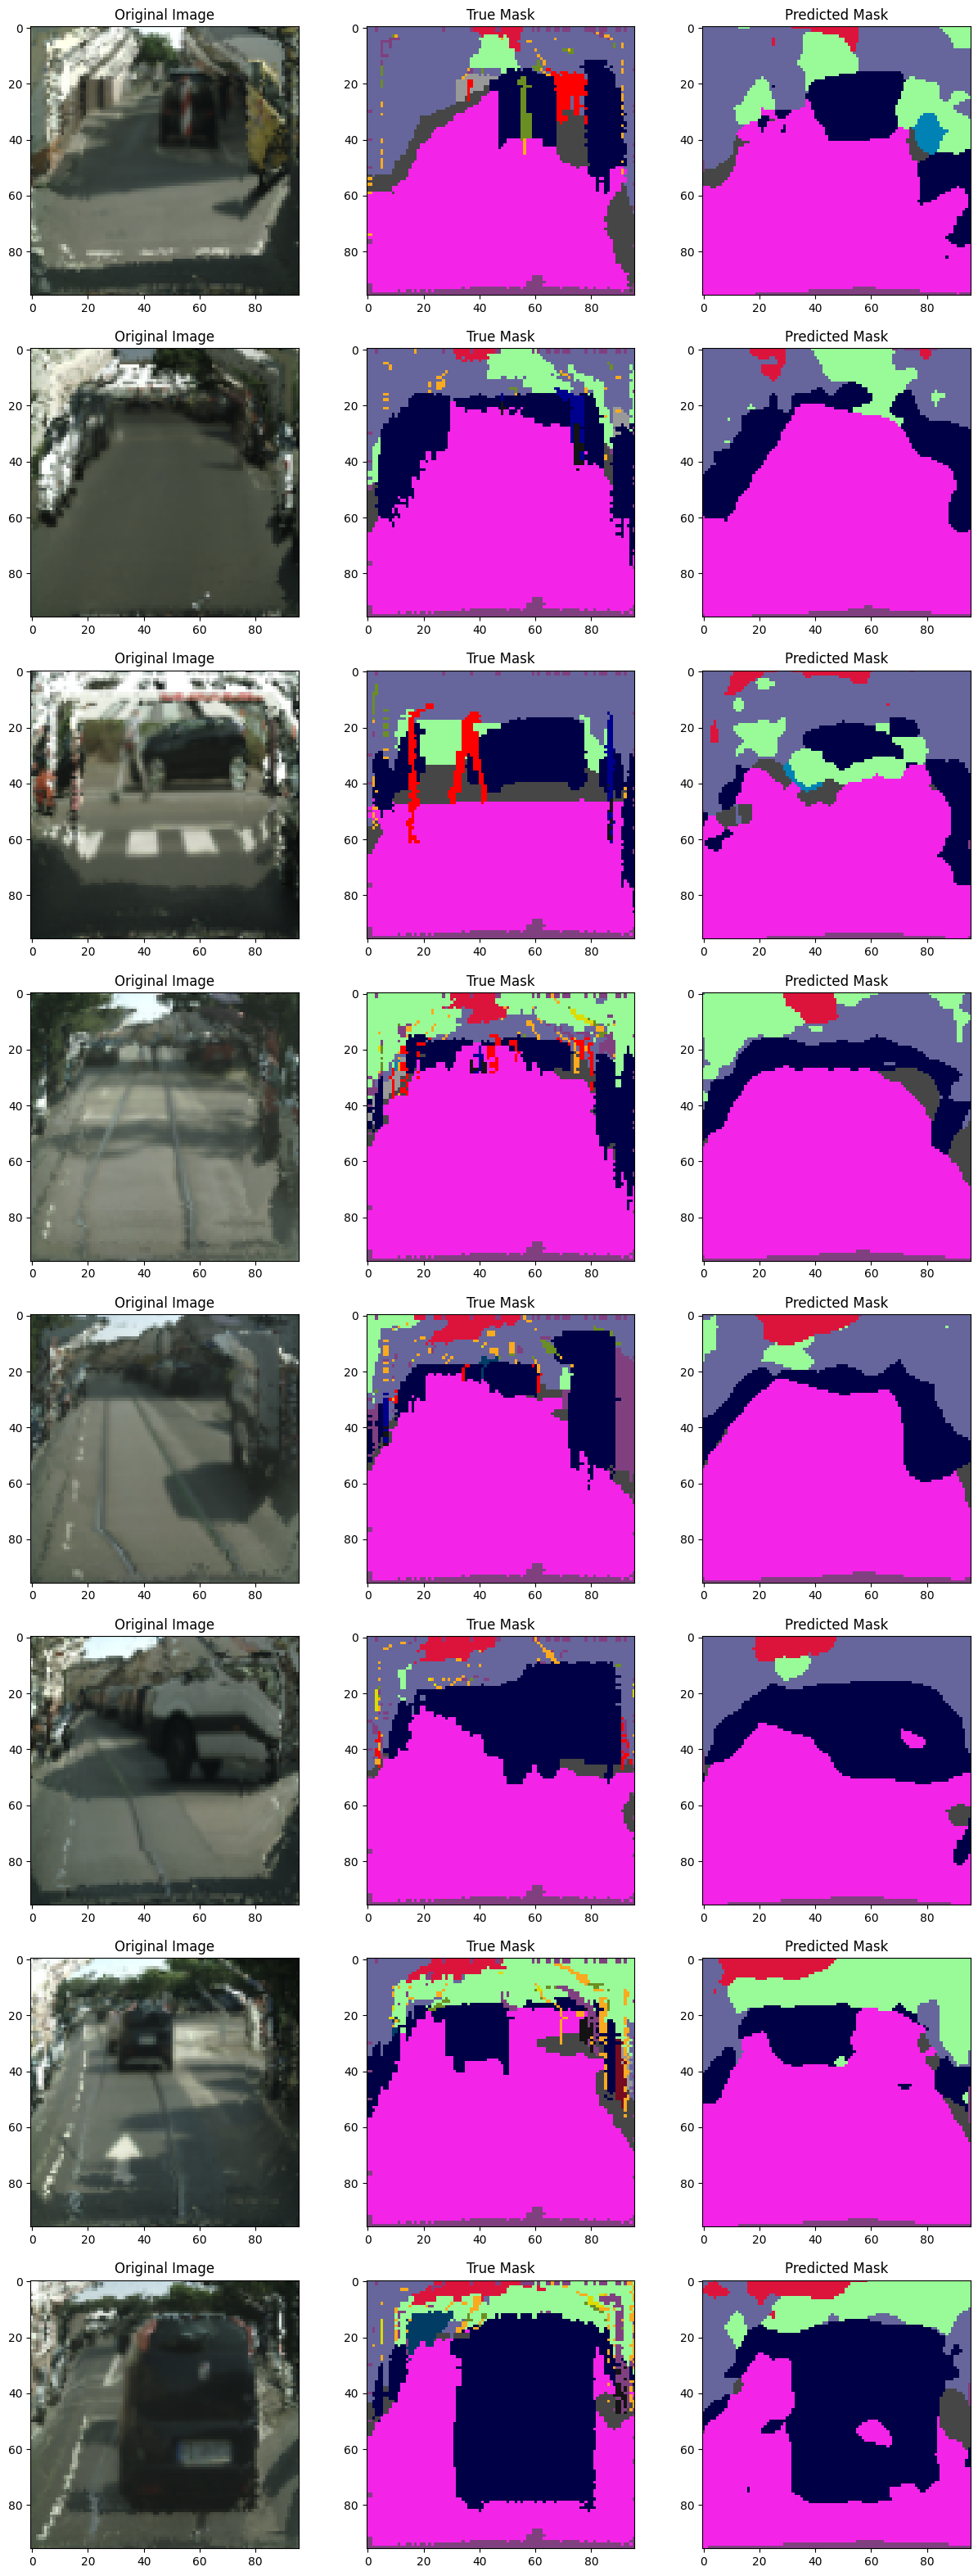

In [15]:
plot_segmentation(images, masks, out)

In [16]:
# How to check if it is realtime 

import time
start = time.time()
out = model.model(images)
end = time.time()
print(f'Time to process a batch: {end - start}')


Time to process a batch: 0.41709351539611816


In [17]:
# When is it considered real time?
# 2. Check the time it takes to process a single image
model.model.eval()
start = time.time()
out = model.model(torch.ones(1, 3, 96, 96))
end = time.time()
print(f'Time to process a single image: {end - start}')
# that would be FPS
print(f'FPS: {1/(end-start)}')

Time to process a single image: 0.13354086875915527
FPS: 7.4883442746169955


In [18]:
transform_reconstruct = transforms.Compose([
    transforms.Resize((81, 81)),
    # model.foveated_transform.foveated_compression.reconstruct
])

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


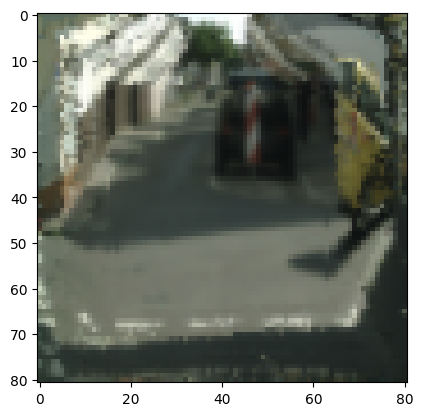

In [25]:
plt.imshow(transform_reconstruct(images[0]*255).permute(1,2,0).numpy().astype(np.uint8))

In [27]:
reconstructed = model.foveated_transform.foveated_compression.reconstruct(np.array(transform_reconstruct(images[0]*255), dtype=np.uint8))

(3, 81, 81)
(6561,)


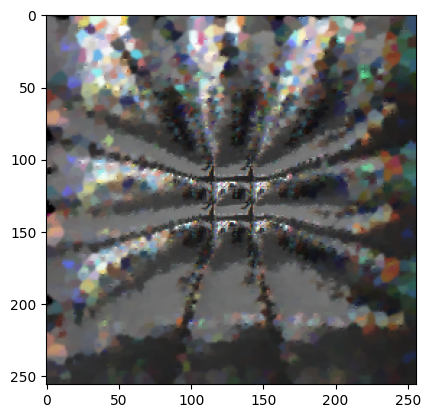

In [20]:
plt.imshow(reconstructed[1])

In [21]:
np.array(images[0])

array([[[0.3647059 , 0.34969366, 0.34748775, 0.3543505 , 0.3584559 ,
         0.35404414, 0.36066177, 0.36403188, 0.3647059 , 0.36268383,
         0.39883578, 0.46666664, 0.4668505 , 0.47015932, 0.47058824,
         0.46832108, 0.46997547, 0.58596814, 0.86066175, 0.6025736 ,
         0.4976103 , 0.811152  , 1.        , 0.78253675, 0.34197304,
         0.3627451 , 0.25686276, 0.28333333, 0.683701  , 1.        ,
         0.9797794 , 0.91832113, 0.96795344, 0.6362745 , 0.40189952,
         0.5148897 , 0.8053309 , 0.9316177 , 0.94485295, 0.95159316,
         0.95030636, 0.9591299 , 0.96721816, 0.9655025 , 0.9678921 ,
         0.95465684, 0.9529412 , 0.97107846, 0.9843137 , 0.9853554 ,
         0.9886642 , 0.99197304, 0.9952818 , 0.9960784 , 0.9941789 ,
         0.7425245 , 0.23541667, 0.25520834, 0.27175245, 0.38204658,
         0.36096814, 0.35490197, 0.42218137, 0.38664216, 0.32708335,
         0.3425858 , 0.34901962, 0.35790443, 0.36047795, 0.34117648,
         0.34117648, 0.34442404, 0